In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.drmad_optimize import drmad_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import theano.tensor as T

In [2]:
X_train, X_test = np.load('../../../data/W_X_Tr.npy'), np.load('../../../data/W_X_Test.npy')
Y_train, Y_test = np.load('../../../data/W_Y_Tr.npy'), np.load('../../../data/W_Y_Test.npy')

param_num = X_train.shape[1] * 50 + 50 + 50  + 1

lr = theano.shared(10**(-5))
alphas = theano.shared(np.array([1.0, 1.0]))
real_alphas = T.concatenate([T.repeat(alphas[0],  X_train.shape[1] * 50 + 50)   , T.repeat(alphas[1],  50 + 1) ])
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [X_train.shape[1],50, 1],   init_sigmas=[0.001]*3, nonlinearity=lambda x:T.nnet.relu(x), log_alphas =real_alphas, bias=True)

#for test
alphas.set_value(np.array([12., 1.0]))
print alphas.eval()
print real_alphas.eval()

[ 12.   1.]
[ 12.  12.  12. ...,   1.   1.   1.]


In [ ]:
hyp_lr_range = [10**(-1)] 
print 'calbirate: alpha'
found = False
for h in [  [np.array([-5.0,-5.0])],
            
             [np.array([5.0, 5.0])]]:
    print h
    while True:

            
            
            alphas.set_value(h[0])



            score = drmad_optimize(partial(cv_tc, k =4,  batch_size=25), model_build, optimizer, 5, 25, 100,  X_train, Y_train, 
    [alphas], lr,  lr=hyp_lr_range[0],  lr_for_learning_rate=0.0, verbose=10, use_hessian=False).history[-1][1]
            if lr.eval()>1.0 or np.max(abs(alphas.eval()))>12 or  np.isnan(score) or np.isinf(score):
                print 'BAD'
                hyp_lr_range[0] = hyp_lr_range[0]/10
            else:
                
                break
            
print 'final', hyp_lr_range            
        
        
        


calbirate: alpha
[array([-5., -5.])]


In [45]:
bests = []
bests = []
for _ in xrange(50):
    print 'attemp'
    
    hyp_lr_range = [0.001, 10**(-10)] 
    lr_value = 10.0**(-2)
    alphas_value =random.choice(alpha_ranges)
    print alphas_value, lr_value
    lr.set_value(lr_value)
    alphas.set_value(alphas_value)

    
    lr.set_value(lr_value)
    alphas.set_value(alphas_value)
    
    bests.append( drmad_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 75, 10,  X_train, Y_train, 
    [alphas], lr,  lr=10.0**(-1),  lr_for_learning_rate=0.0,use_hessian=False, verbose=-1))
    print 'final', alphas.eval(), lr.eval()

attemp
[ 10.36163292   0.        ] 0.01
final [ nan  nan] 0.01
attemp
[ 1.15129255  4.60517019] 0.01
final [ 2.99659985  4.60515937] 0.01
attemp
[ 5.75646273  4.60517019] 0.01


KeyboardInterrupt: 

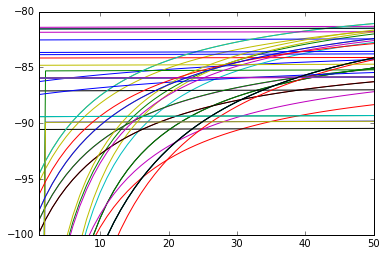

In [41]:
#bests = bests2[:]
import cPickle
#with open('results_cv_mad.pckl','rb') as inp:
#    bests = cPickle.load(inp)
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
    plt.plot(history)
plt.ylim((-100, -80))
plt.xlim((1,50))

import cPickle
with open('results_cv_mad.pckl','wb') as out:
    cPickle.dump(bests, out)


In [11]:
import theano.tensor as T
X = T.matrix()
result = []
models = []
predicts = []

for m in xrange(4):
    models.append(model_build(dataset_size=100))
    predict = models[m].predict_var(X)
    predicts.append(theano.function([X], predict))
for b in bests:
    scores = [b.history[i][1] for i in xrange(len(b.history))]
    best = np.argmax(scores)
    
    for m in xrange(4):
        #print b.history[best][2][m]
        models[m].params.set_value(b.history[best][2][m])
        result.append(np.mean((predicts[m](X_test)[:,0]-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """

print np.mean(result)
print np.std(result)

IndexError: tuple index out of range

In [8]:
import theano.tensor as T
X = T.matrix()
result = []
for b in bests:
    print b.best_values
    alphas.set_value(b.best_values[0])
    lr.set_value(b.best_values[1])
    training_procedure = cv_tc( model_build, optimizer, X_train, Y_train, validation_part=0.0, batch_size=100 )
    
    for i in xrange(10):
        training_procedure.do_train()
    
    for m in training_procedure.models:
        predict = m.predict_var(X)
        predict = theano.function([X], predict)
    
        result.append(np.mean((predict(X_test)[:,0]-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """
print np.mean(result)
print np.std(result)

[array([-0.08618924,  0.07302104]), array(0.00537222563090441)]
0.845032090759
[array([-0.11002089,  0.01758332]), array(0.005550579267265482)]
0.845271989877
[array([-0.08656351,  0.03525381]), array(0.005229430710384838)]
0.845044330333
[array([-0.14659154,  0.08547611]), array(0.005252349082338278)]
0.845831519337
[array([-0.08937141,  0.00927595]), array(0.0056384881157805575)]
0.845004327496
[array([-0.08553674,  0.06774782]), array(0.005466402939404961)]
0.845007862766
[array([-0.12797675,  0.05814624]), array(0.005692692163875986)]
0.845512133854
[array([-0.09096783,  0.05599656]), array(0.005646202917547017)]
0.845048543537
[array([-0.07663557,  0.00206454]), array(0.005492577281170933)]
0.844863140164
[array([-0.02383022,  0.01895683]), array(0.01000018614027096)]
0.844238832863
0.845085477098
0.000394735187971


In [9]:
best_values = []
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
        best_values.append(history[-1])
print np.mean(best_values)

-115.117619924


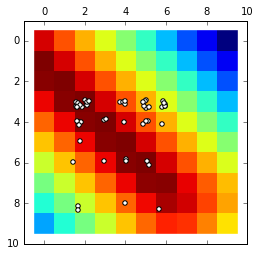

In [13]:
plt.matshow(matrix.T)
for i in bests:
    i = i.best_values[0]
    i = np.log10(np.exp(i)**2)
    if i[0]>10 or i[1] >10:
        continue
    
    plt.scatter(i[0]+np.random.randn(1)*0.1,i[1]+np.random.randn(1)*0.1, c='w')

In [23]:
bests[0].best_values[0]

array([ 6.85777626,  3.48233214])

UnboundLocalError: local variable 'X2' referenced before assignment

[([array([  31.6227766 ,  316.22776602]), 0.001], array(-127.64285224474986)),
 ([array([ 10.        ,   3.16227766]), 0.01], array(-162.5087255392545)),
 ([array([ 31.6227766 ,   3.16227766]), 0.01], array(-2.7627426873481633e+42)),
 ([array([  10.,  100.]), 0.005], array(-124.3719052719263)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-1.2198974168241432e+41)),
 ([array([ 316.22776602,    1.        ]), 0.001], array(-122.78697142872564)),
 ([array([ 1.,  1.]), 0.01], array(-2.048288202990528e+45)),
 ([array([ 316.22776602,   10.        ]), 0.02], array(nan)),
 ([array([   1.,  100.]), 0.005], array(-127.03124347465777)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-3.879875247817619e+79))]

In [11]:
for i in bests:
    print np.array(i.best_values[0])**2

[  1.00000000e+05   1.00000000e+00]
[ 100.  100.]
[ 100.  100.]
[   1.  100.]
[  1.  10.]


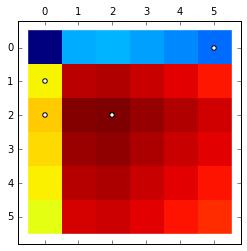

In [12]:
plt.matshow(matrix)
for i in bests:
    i = i.best_values[0]**2
    i = np.log10(i)
    
    plt.scatter(i[0],i[1], c='w')